### Table of contents<a class='anchor' id='top'></a>
- [Importing Packages](#1)
- [Define Functions](#2)
- [Importing Data](#3)
- [Selecting a Feature](#4)


# 1. Importing Packages <a class='anchor' id='1'></a> [↑](#top)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import random
from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

from scipy import stats

# 2. Define Functions <a class='anchor' id='2'></a> [↑](#top)

In [2]:
##Define Functions for the normalization of the Datasets
def min_max_norm(data):
    data = (data - data.min())/(data.max()-data.min())
    return data

def retransform(data,min = min,max = max):
    data = data * (max-min) + min
    return data

def rescale(data,min,max):
    return retransform(min_max_norm(data),min,max)

def plot_data(data,colname = "test"):
    plt.figure(figsize=(8, 4))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
    plt.title(colname)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

def plot_time_series(dataframe,col="test"):
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe[col], marker='')
    plt.title(col)
    plt.ylim(17,20)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

# 3. Importing Data <a class='anchor' id='3'></a> [↑](#top)

In [76]:
real_dataset = pd.read_csv("real_dataset.csv",index_col = 0)
real_dataset.head()

,Stage1.Output.Measurement9.U.Actual
330,17.95
331,17.95
332,17.95
333,18.09
334,18.09


# 4. Analyse Seasonality <a class='anchor' id='4'></a> [↑](#top)

In order to generate the synthetic data we want to isolate the trend and seasonaliy component from the residuals of the time series. Since we do not know of any inherent seasonaliy in the dats we find the seasonality, which maximizes the residuals.

In [28]:
def get_msr(result):
    return sum((result.resid.dropna())**2)/len(real_dataset.iloc[:,0])


In [29]:

periods = [10*(x+1) for x in range(600)]
msrs = []

for i in periods:
     result = seasonal_decompose(real_dataset.iloc[:,0], model='additive',period=i)
     msrs.append(get_msr(result))


We find the value that maximizes the residuals is a seasonality of 850

In [32]:
periods[np.argmax(msrs)]

850

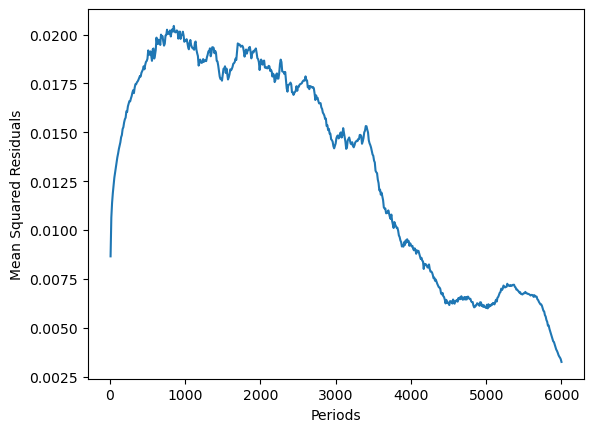

In [30]:
plt.plot(periods,msrs)
plt.xlabel("Periods")
plt.ylabel("Mean Squared Residuals")
plt.show()

This leads to the following decomposition.

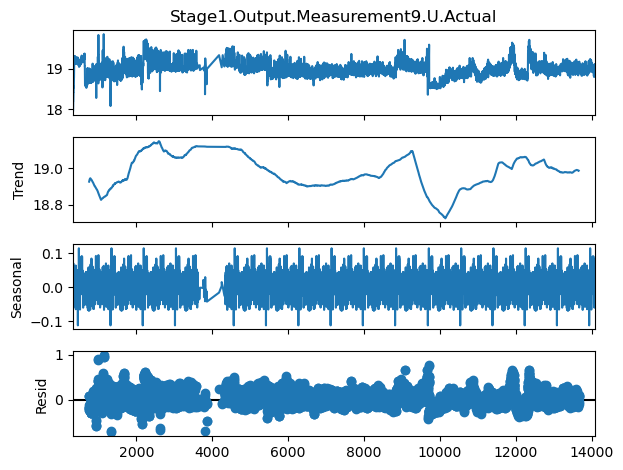

In [31]:
sd = seasonal_decompose(real_dataset.iloc[:,0], model='additive',period=850)
sd.plot()
plt.show()

In [38]:
times_series_decomposition = pd.DataFrame(sd.resid)
times_series_decomposition.insert(0, "seasonal",sd.seasonal)
times_series_decomposition.insert(0, "trend",sd.trend)
times_series_decomposition = times_series_decomposition.dropna()
(times_series_decomposition)


,trend,seasonal,resid
755,18.926542,-0.022881,-0.163661
756,18.927683,-0.066294,-0.121389
757,18.928825,-0.057709,-0.191116
758,18.929889,-0.050446,-0.199443
759,18.930877,-0.039839,-0.231038
...,...,...,...
13658,18.987313,-0.020639,-0.056674
13659,18.987289,-0.007280,0.069990
13660,18.987266,0.006080,0.056654
13661,18.987072,-0.017889,0.090817


# 5. Generate Synthetic Residuals <a class='anchor' id='5'></a> [↑](#top) 
In order to combine the real dataset with our synthetic data. Our goal is to sample synthetic residuals from certain distributions. Therefore we generate characteristic data with a given shape and map the domain to match the range of the real residuals.

In [82]:
mean = real_dataset.mean()
std =real_dataset.std()
min = real_dataset.min()
max = real_dataset.max()
real_dataset = np.array(real_dataset).reshape(1,-1)[0]

length = len(real_dataset)



Since we rescale the data according to our residuals, the parameters are "almost" arbitrary.

In [83]:
rng = np.random.default_rng() 
exponential_dataset = np.random.exponential(std,length)
gamma_dataset = np.random.gamma(mean,std,length)
pareto_dataset = np.random.pareto(20,length)
power_dataset = np.random.power(std,length)
gumbel_dataset = np.random.gumbel(mean,std,length)
laplace_dataset = np.random.laplace(mean,std,length)
logistic_dataset = np.random.logistic(mean,std,length)
lognormal_dataset = np.random.lognormal(mean,std,length)

bimodal_lognormal_dataset1 = np.random.lognormal(mean-0.7,std,int(length/2))
bimodal_lognormal_dataset2 = np.random.lognormal(mean+0.7,std,int(length/2))
bimodal_lognormal_dataset = np.concatenate([bimodal_lognormal_dataset1,bimodal_lognormal_dataset2])
rng.shuffle(bimodal_lognormal_dataset)

rayleigh_dataset = np.random.rayleigh(std,length)
vonmises_dataset = np.random.vonmises(mean,std,length)
triangular_dataset = np.random.triangular(min,mean,max,length)
uniform_dataset = np.random.uniform(min,max,length)
wald_dataset = np.random.wald(mean,200,length)
weibull_dataset = np.random.weibull(1.5,length)

normal_dataset = np.random.normal(mean,std,length)


bimodal_normal_symmetric_dataset1 = np.random.normal(mean-0.7,std,int(length/2))
bimodal_normal_symmetric_dataset2 = np.random.normal(mean+0.7,std,int(length/2))
bimodal_normal_symmetric_dataset = np.concatenate([bimodal_normal_symmetric_dataset1, bimodal_normal_symmetric_dataset2])
rng.shuffle(bimodal_normal_symmetric_dataset)

bimodal_normal_asymmetric_dataset1 = np.random.normal(mean-0.7,std,int(length/3))
bimodal_normal_asymmetric_dataset2 = np.random.normal(mean+0.7,std, 1+ int(2* (length/3)))
bimodal_normal_asymmetric_dataset = np.concatenate([bimodal_normal_asymmetric_dataset1, bimodal_normal_asymmetric_dataset2])
rng.shuffle(bimodal_normal_asymmetric_dataset)

datasets = [real_dataset,exponential_dataset,gamma_dataset,pareto_dataset,power_dataset,gumbel_dataset,
            laplace_dataset,logistic_dataset,lognormal_dataset,bimodal_lognormal_dataset,
            rayleigh_dataset,vonmises_dataset,triangular_dataset,uniform_dataset,wald_dataset,
            weibull_dataset,normal_dataset,bimodal_normal_symmetric_dataset,bimodal_normal_asymmetric_dataset,
            ]
datasets_names = [
    "real_dataset",
    "exponential_dataset",
    "gamma_dataset",
    "pareto_dataset",
    "power_dataset",
    "gumbel_dataset",
    "laplace_dataset",
    "logistic_dataset",
    "lognormal_dataset",
    "bimodal_lognormal_dataset",
    "rayleigh_dataset",
    "vonmises_dataset",
    "triangular_dataset",
    "uniform_dataset",
    "wald_dataset",
    "weibull_dataset",
    "normal_dataset",
    "bimodal_normal_symmetric_dataset",
    "bimodal_normal_asymmetric_dataset"
]

In [92]:
residuals = times_series_decomposition["resid"]
residuals = residuals.dropna()
min = residuals.min()
max = residuals.max()

In [93]:
##Define Functions for the normalization of the Datasets
def min_max_norm(data):
    data = (data - data.min())/(data.max()-data.min())
    return data

def retransform(data,min = min,max = max):
    data = data * (max-min) + min
    return data

def rescale(data):
    return retransform(min_max_norm(data))

In [96]:
normalized_datasets = np.array([rescale(x) for x in datasets[1:]])
dataframe = pd.DataFrame(normalized_datasets.T)
dataframe.columns = datasets_names[1:]
#dataframe.insert(0,"time_stamp", time_array)
dataframe.head()

,exponential_dataset,gamma_dataset,pareto_dataset,power_dataset,gumbel_dataset,laplace_dataset,logistic_dataset,lognormal_dataset,bimodal_lognormal_dataset,rayleigh_dataset,vonmises_dataset,triangular_dataset,uniform_dataset,wald_dataset,weibull_dataset,normal_dataset,bimodal_normal_symmetric_dataset,bimodal_normal_asymmetric_dataset
0,-0.542930,-0.082771,-0.463172,-0.531826,-0.162874,0.293543,0.410565,-0.132924,-0.014638,0.054648,-0.619769,-0.636347,-0.286126,-0.480715,-0.185379,0.183278,-0.469458,-0.476732
1,-0.678609,-0.073871,-0.615810,-0.733540,-0.235304,0.246937,0.322174,-0.517330,-0.616487,-0.076910,0.295260,0.133888,-0.000634,-0.592711,-0.696703,-0.005562,0.689964,0.316144
2,-0.338129,-0.369890,-0.680935,-0.682265,-0.169236,0.247813,0.137640,0.099085,0.241262,0.339330,-0.587738,0.214324,0.138728,-0.158109,-0.456217,0.169425,-0.489101,0.403673
3,-0.583856,-0.332740,-0.544148,0.619542,-0.391268,0.231699,0.170671,-0.502268,-0.659530,-0.261682,0.525596,0.392210,0.119446,-0.378589,-0.719231,-0.044882,0.547904,-0.326941
4,-0.733350,-0.071651,-0.724154,-0.699395,0.109518,0.203610,-0.054792,-0.276058,-0.584865,-0.243977,0.270465,-0.492877,0.371694,-0.351000,-0.367602,0.145835,-0.194884,0.515846


The following gives a visualization of all the residuals we generated.

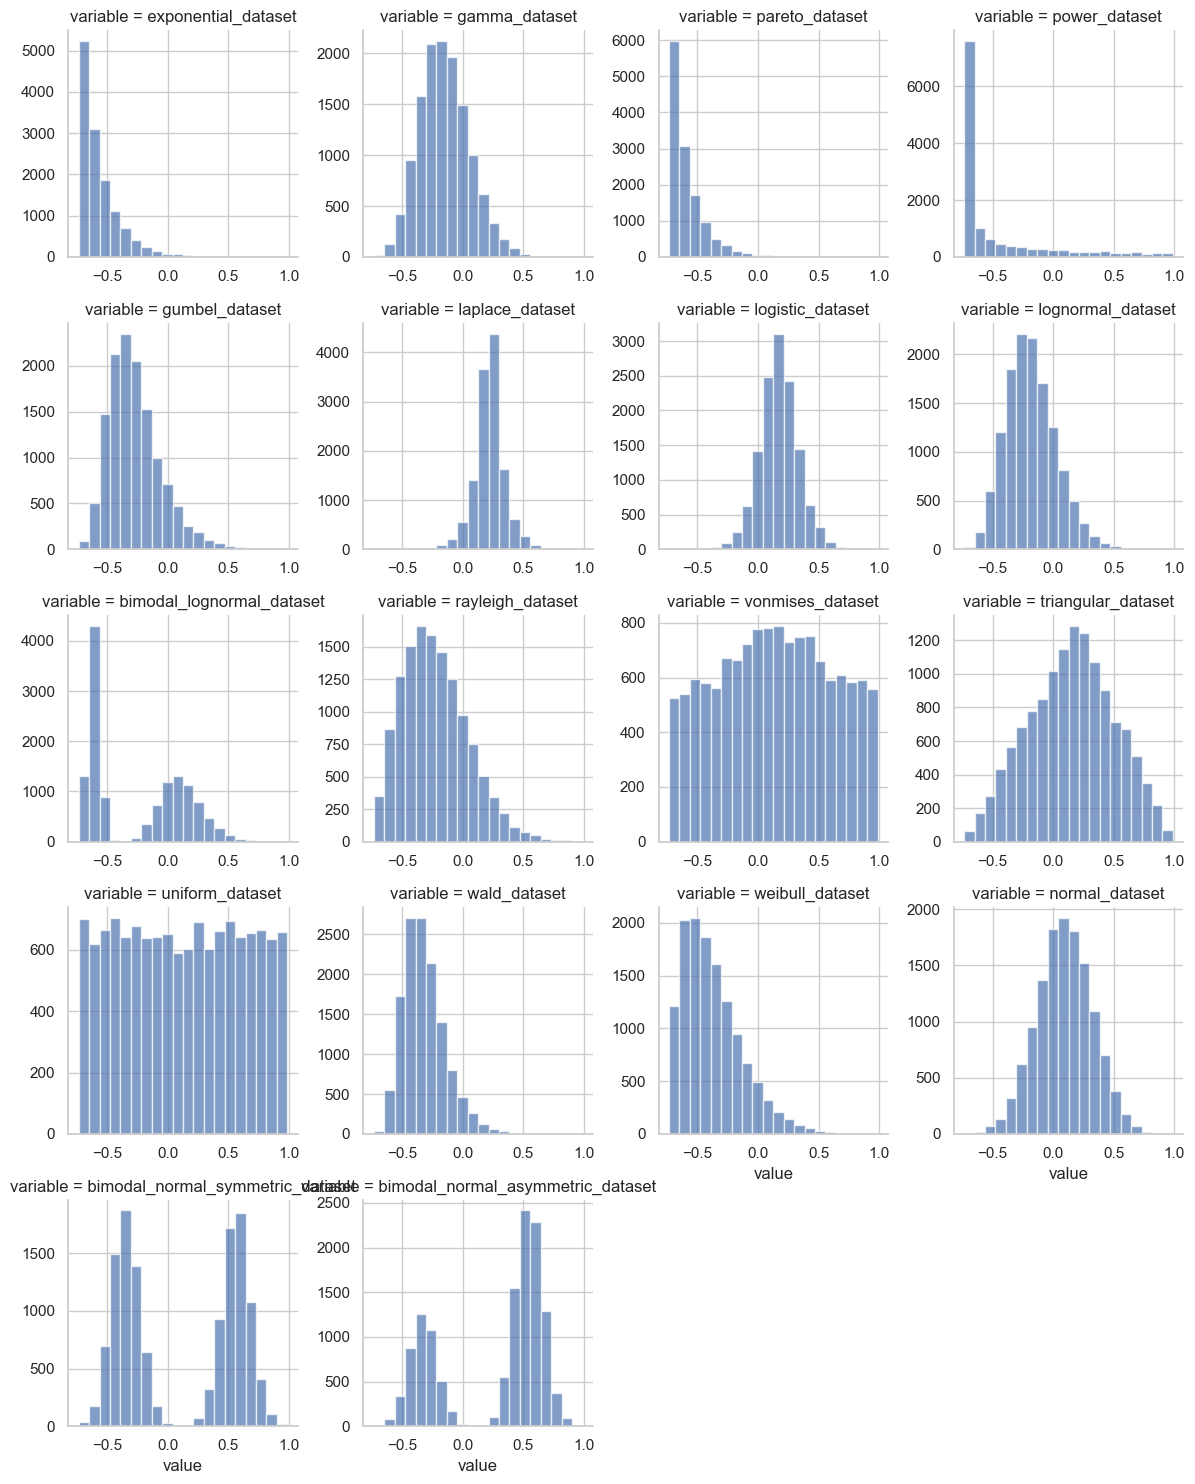

In [104]:
import seaborn as sns
sns.set(style="whitegrid")
grid = sns.FacetGrid(pd.melt(dataframe, value_vars=df.columns), col="variable", col_wrap=4, sharex=False, sharey=False)
grid.map(plt.hist, "value", bins=20, alpha=0.7)
grid.fig.tight_layout(w_pad=1)
plt.show()

In [6]:
unstructured_data = unstructured_data.drop("Unnamed: 0",axis = 1)
time_series = time_series.drop("Unnamed: 0",axis = 1)

In [8]:
rescaled_data = unstructured_data.iloc[:,2:].apply(lambda x:rescale(x, min,max) )

In [9]:
time_series_residuals = pd.concat([time_series,rescaled_data],axis = 1)
time_series_residuals

,trend,seasonal,resid,exponential_dataset,gamma_dataset,pareto_dataset,power_dataset,gumbel_dataset,laplace_dataset,logistic_dataset,...,bimodal_lognormal_dataset,rayleigh_dataset,vonmises_dataset,triangular_dataset,uniform_dataset,wald_dataset,weibull_dataset,normal_dataset,bimodal_normal_symmetric_dataset,bimodal_normal_asymmetric_dataset
0,NaN,0.027700,NaN,-0.593016,-0.429691,-0.722208,-0.628180,-0.502530,0.184556,0.155473,...,-0.239558,-0.375386,0.254097,0.500765,0.211399,-0.244801,-0.640607,0.345236,0.459313,0.525073
1,NaN,0.029834,NaN,-0.617039,0.161118,-0.503544,-0.223766,-0.565189,-0.005628,0.149707,...,-0.713357,-0.005176,-0.175851,0.085680,-0.639177,-0.541786,-0.576478,-0.105688,-0.139277,0.340352
2,NaN,0.023395,NaN,-0.621933,-0.259157,-0.722726,0.739191,-0.244859,-0.045322,0.224916,...,-0.615632,0.100353,-0.709645,0.374192,0.411520,-0.351651,-0.601908,-0.000412,-0.254858,0.314459
3,NaN,0.009095,NaN,-0.483980,-0.069211,-0.506774,-0.586514,-0.271174,0.075703,0.198343,...,0.103168,-0.321688,-0.670104,0.412771,0.531112,-0.479410,-0.389554,-0.130412,0.020519,0.395872
4,NaN,0.016224,NaN,-0.669745,-0.147457,-0.568634,0.601621,-0.331820,0.010274,0.147312,...,-0.572560,-0.655310,0.624458,0.007338,0.943703,-0.240654,-0.332330,0.193446,-0.149977,-0.505540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,NaN,-0.017654,NaN,-0.617293,-0.178302,-0.657768,-0.305188,-0.560355,-0.100788,0.005582,...,-0.093242,0.310898,-0.165120,-0.085593,0.758201,-0.143083,-0.683676,0.200553,-0.333054,0.099000
13024,NaN,-0.027666,NaN,-0.375530,-0.183965,-0.662399,-0.730063,-0.256786,0.039334,0.165046,...,-0.093935,-0.409110,-0.015980,0.394252,0.679085,-0.176834,-0.370567,0.302789,0.602909,0.377168
13025,NaN,0.011597,NaN,-0.654901,-0.484375,-0.446091,-0.699651,-0.483834,-0.026432,0.145741,...,-0.151077,-0.338899,0.898748,-0.238996,-0.508482,-0.372079,-0.601945,0.307465,0.051766,0.686724
13026,NaN,0.018712,NaN,-0.641432,-0.152662,-0.722728,-0.267064,-0.466446,0.088718,-0.092856,...,-0.633182,-0.502762,-0.061445,0.676573,0.907080,-0.126735,-0.483730,-0.119586,0.571808,0.562059


In [50]:
time_series_data = time_series_residuals.iloc[:,2:].apply(lambda x: x + time_series_residuals["trend"]+ time_series_residuals["seasonal"]).dropna()
time_series_data = time_series_data.set_index(np.array(range(0,time_series_data.iloc[:,1].shape[0])),append = False)
time_series_data = pd.concat([ pd.Series(np.array(range(0,time_series_data.iloc[:,1].shape[0]))),time_series_data],axis = 1)
time_series_data = time_series_data.rename(columns={"resid": "real_dataset", 0 : "time_col"})
time_series_data.iloc[:,0:]

,time_col,real_dataset,exponential_dataset,gamma_dataset,pareto_dataset,power_dataset,gumbel_dataset,laplace_dataset,logistic_dataset,lognormal_dataset,bimodal_lognormal_dataset,rayleigh_dataset,vonmises_dataset,triangular_dataset,uniform_dataset,wald_dataset,weibull_dataset,normal_dataset,bimodal_normal_symmetric_dataset,bimodal_normal_asymmetric_dataset
0,0,18.74,18.283644,18.671138,18.298731,18.196414,18.356639,18.790018,18.958178,18.635531,18.188027,18.622892,19.043388,18.423382,18.717713,18.695508,18.377960,19.082301,18.768966,19.328949
1,1,18.74,18.165670,18.679049,18.140290,19.043573,18.429291,18.912311,19.123442,18.300225,18.470726,18.335800,19.459128,18.426365,18.648641,18.748582,18.432358,19.081139,19.055702,18.499732
2,2,18.68,18.161619,18.479493,18.175378,18.139867,19.187532,18.967980,19.064621,18.419445,18.843304,18.486115,18.958065,18.234887,18.804439,18.586352,18.516018,19.014653,19.366642,19.310049
3,3,18.68,18.320108,18.611073,18.220617,18.167941,18.561530,18.899663,18.899802,18.284445,18.189057,18.369755,19.755525,18.671673,19.023652,18.412630,18.324233,19.111521,19.526136,19.433575
4,4,18.66,18.358435,18.669070,18.166731,18.198971,18.499921,19.002696,18.801920,18.441425,18.856382,19.042682,19.154744,18.738334,19.695083,18.303305,18.463904,19.201518,18.559724,19.311492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12173,12173,18.91,18.407184,18.812628,18.326900,18.432303,18.661705,18.931801,19.144368,18.838942,18.293534,18.796664,19.763122,18.946974,18.903358,18.572084,18.470951,18.943529,18.654056,19.635326
12174,12174,19.05,18.270343,18.841064,18.307387,18.852252,18.642841,18.947847,19.173140,18.883654,18.317464,18.517425,18.810231,18.713350,19.379727,18.537101,19.287798,19.402776,19.352337,19.391624
12175,12175,19.05,18.305507,19.082175,18.294187,19.749054,18.641708,19.075031,18.897728,18.718662,18.600072,18.988880,19.137570,19.299487,19.490382,18.675271,19.137596,19.304948,18.786628,18.898721
12176,12176,19.06,18.294367,18.898758,18.254746,18.890501,19.065455,18.962468,19.128122,18.490256,19.047721,18.494411,19.882168,18.571110,19.201948,18.580770,18.481482,18.954252,18.833869,19.504221


In [42]:
time_series_data.to_csv("data_final")

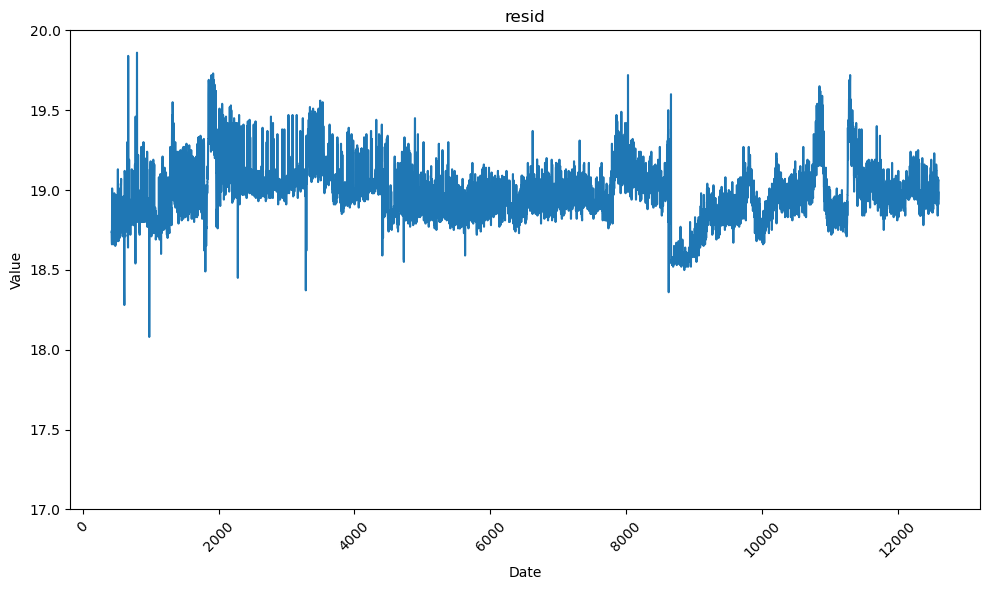

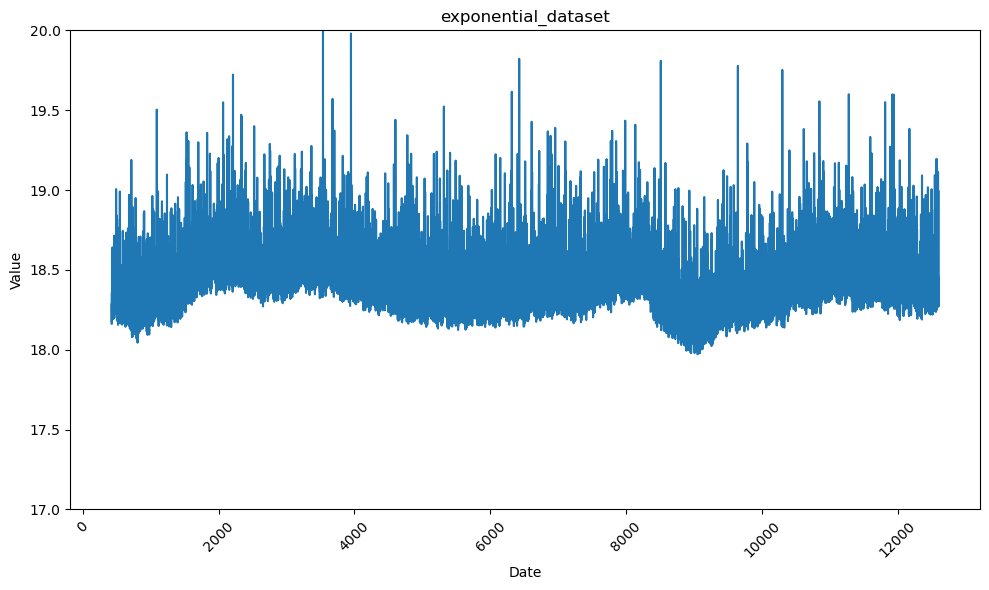

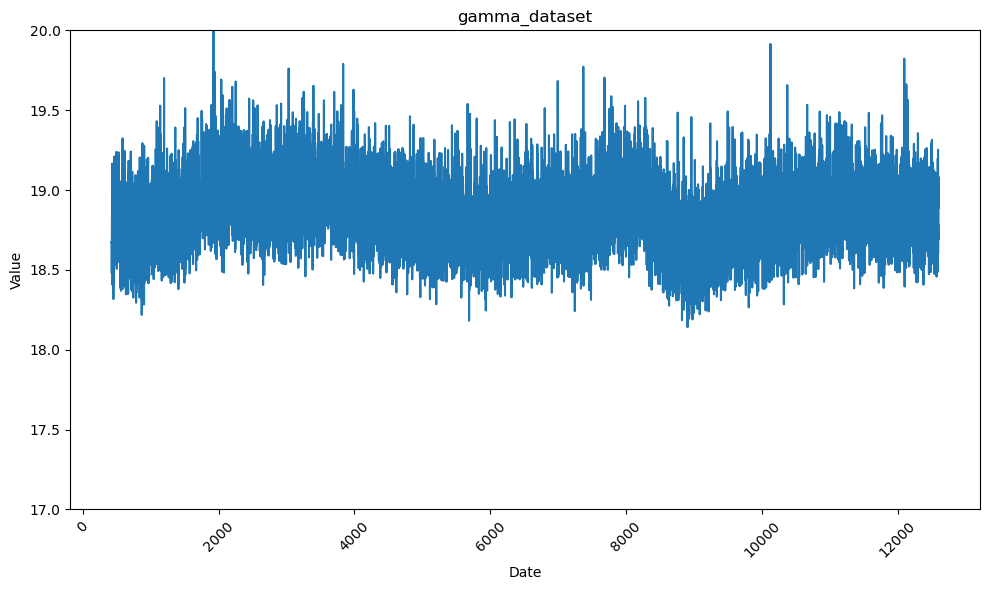

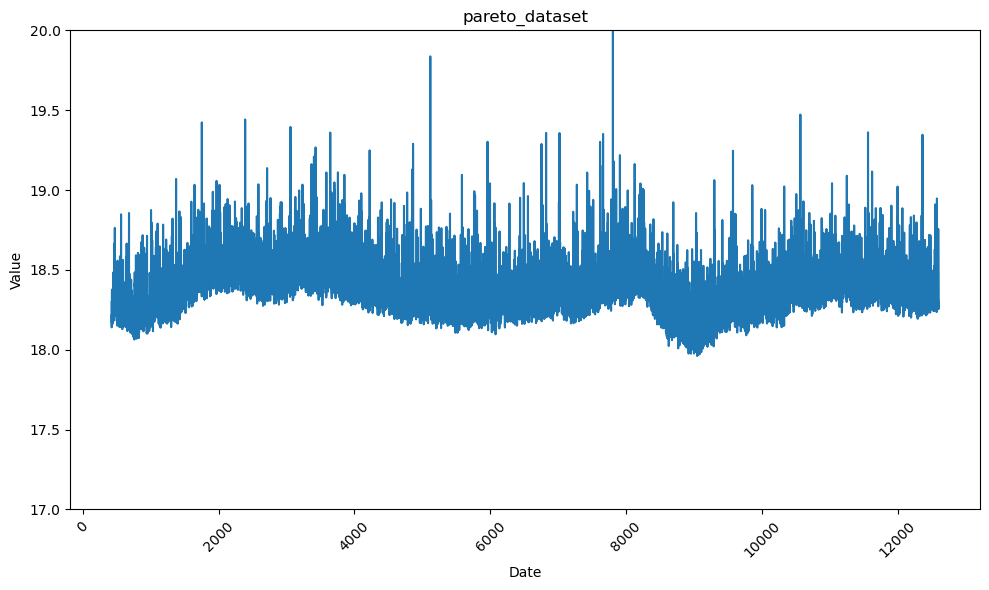

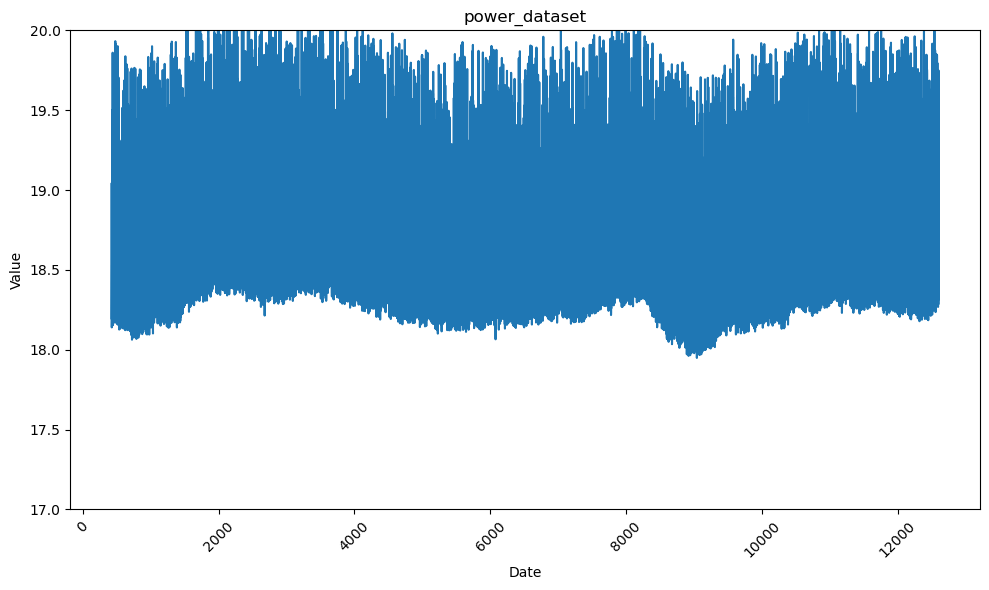

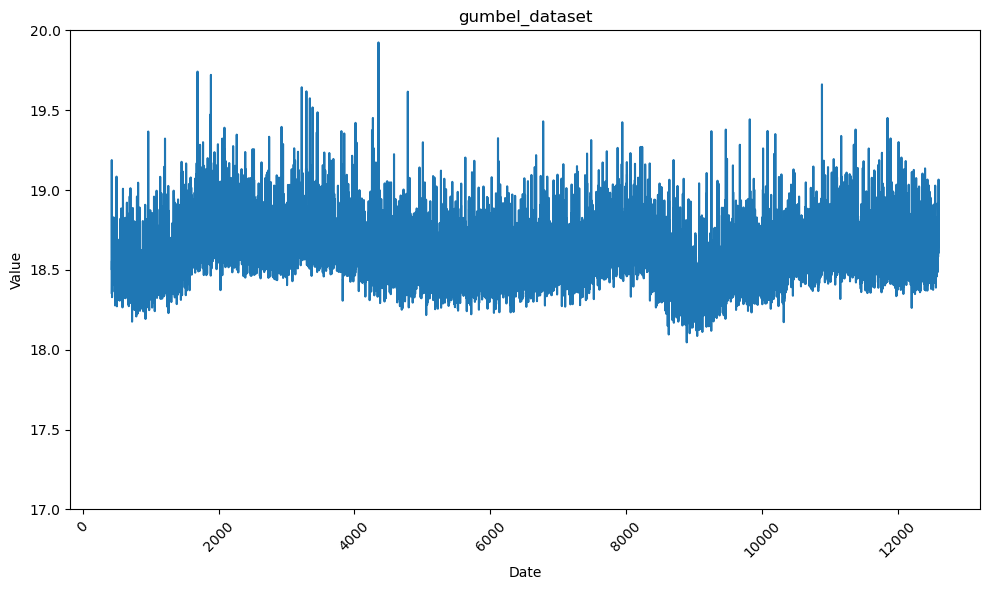

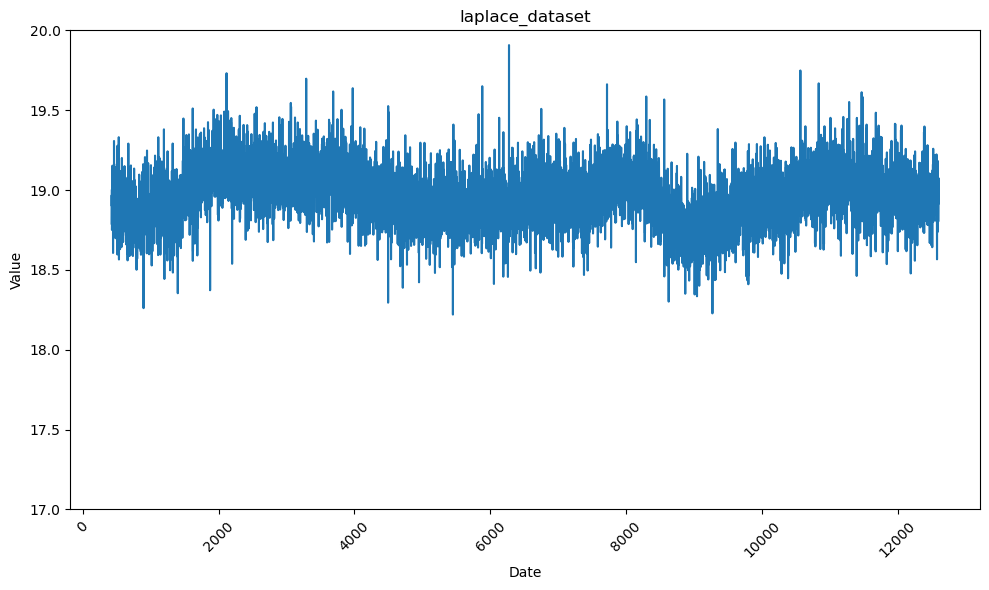

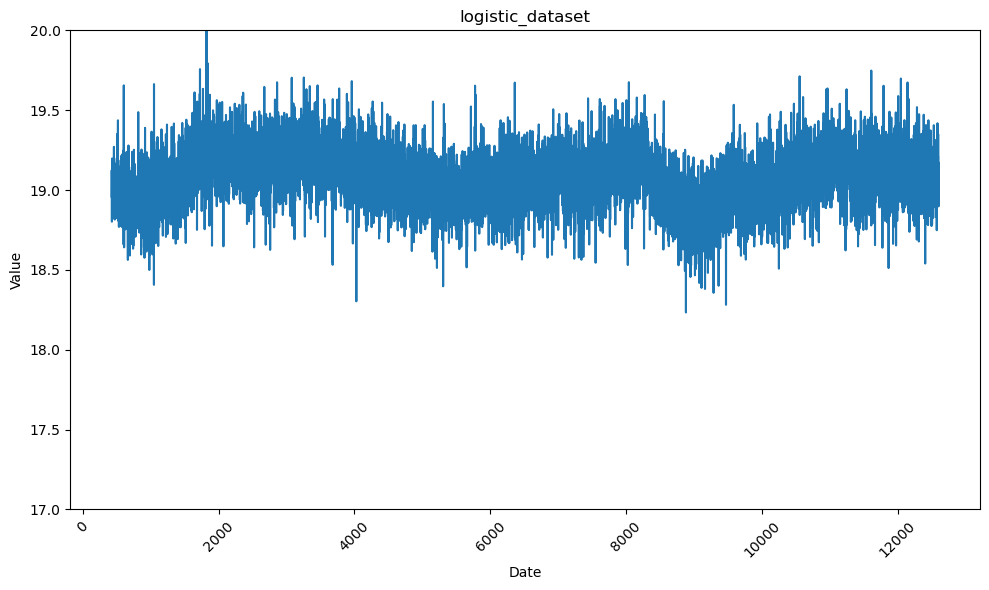

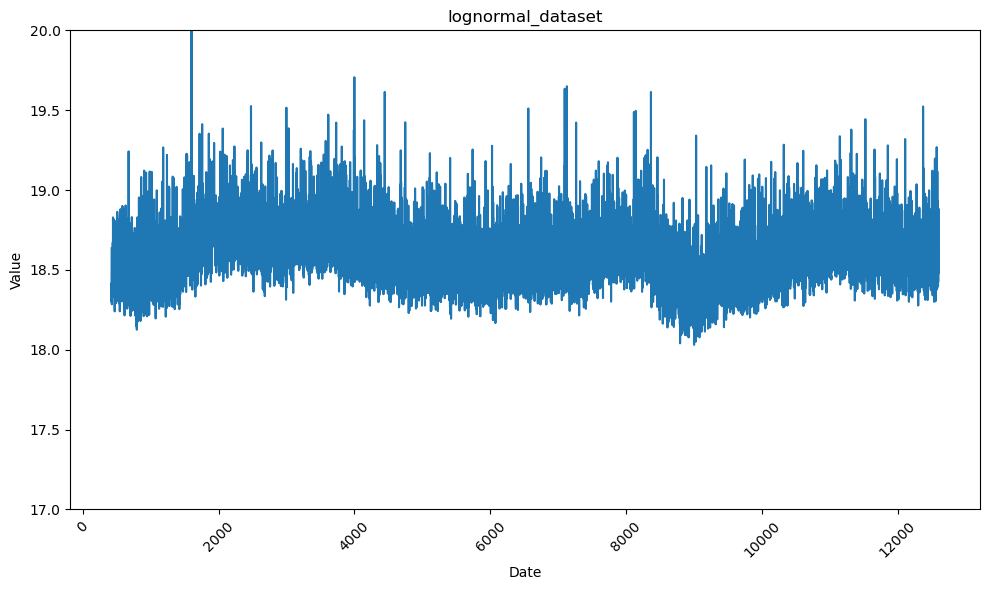

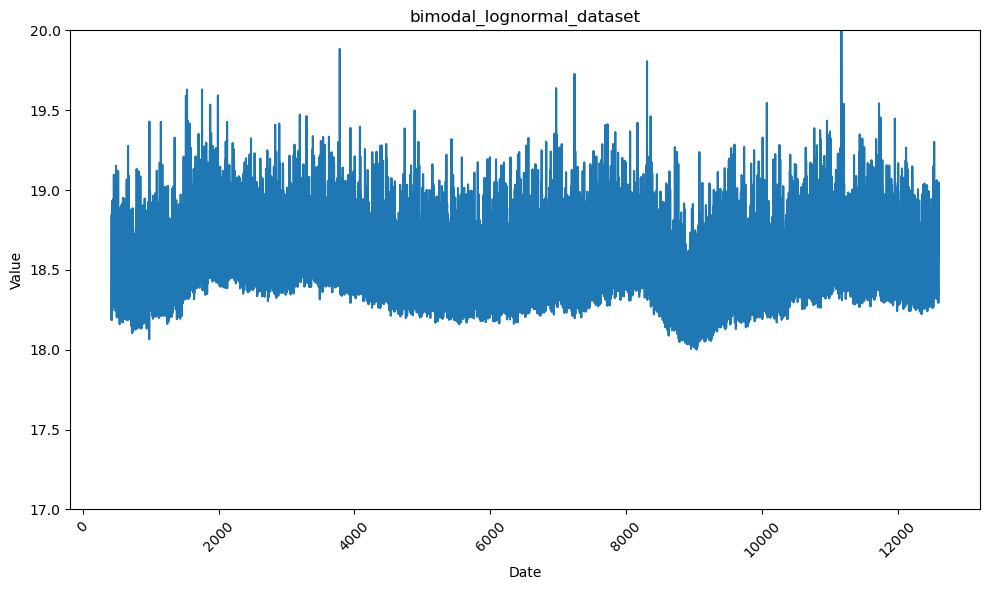

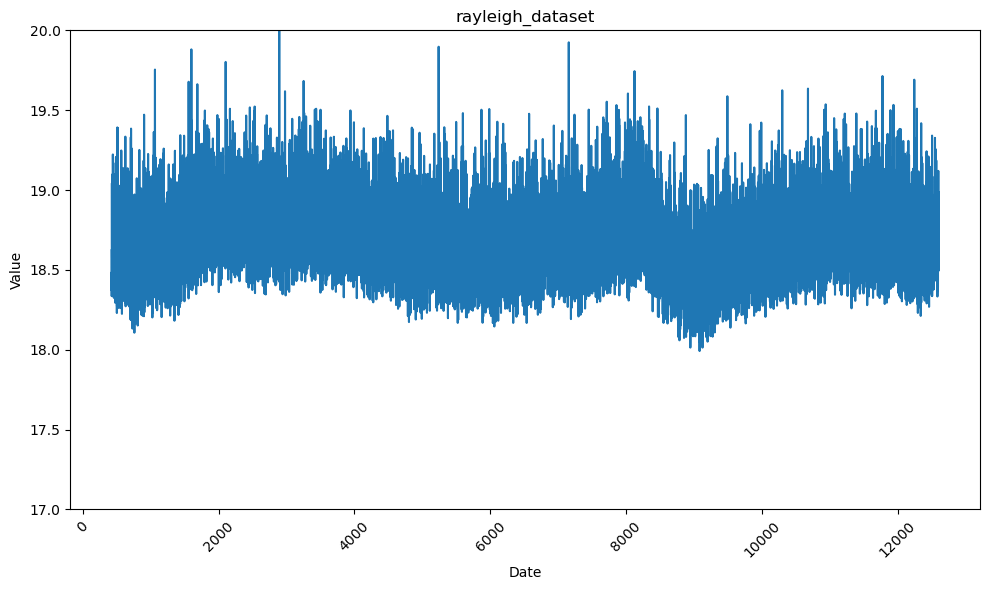

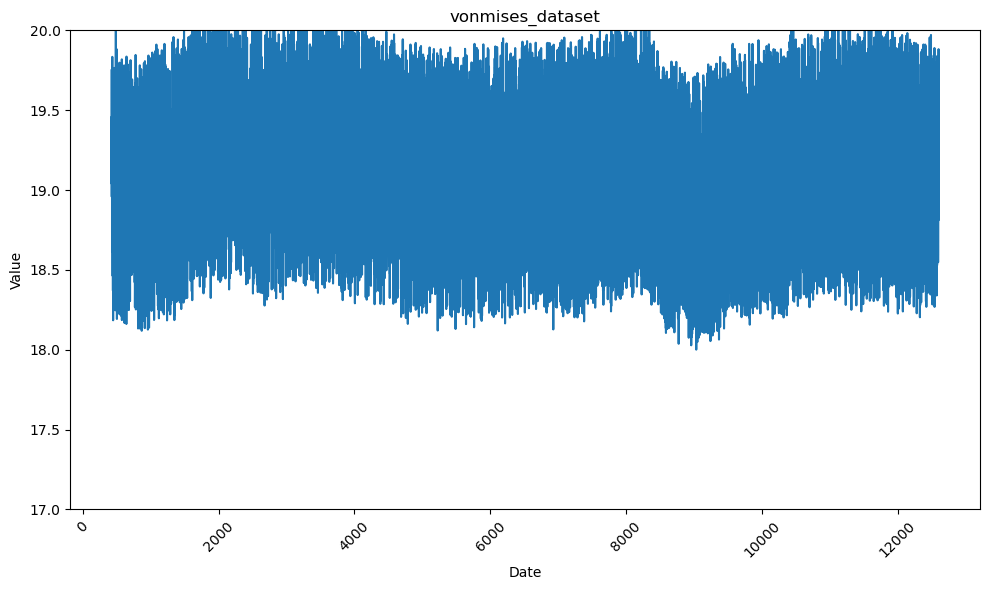

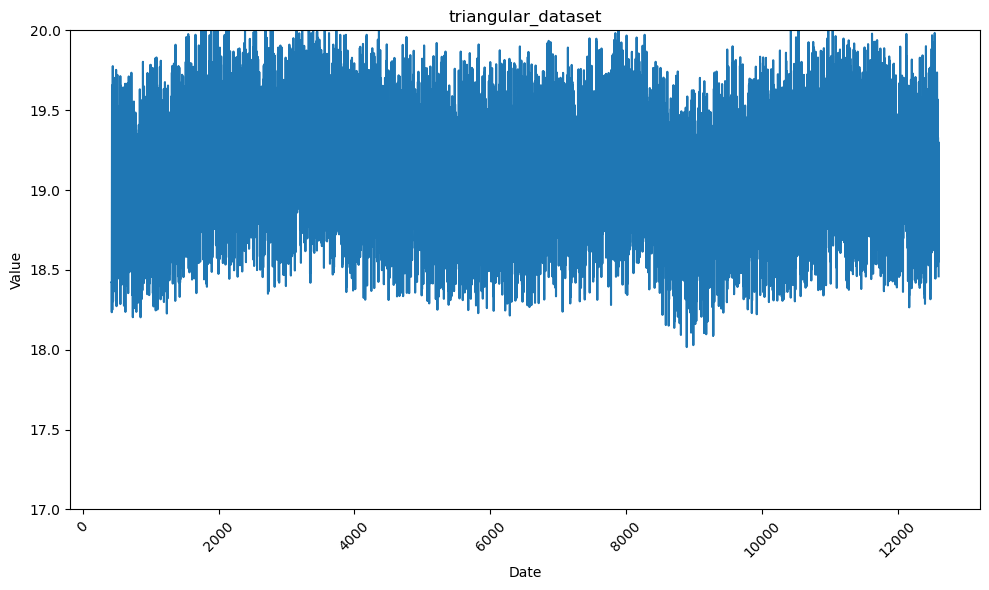

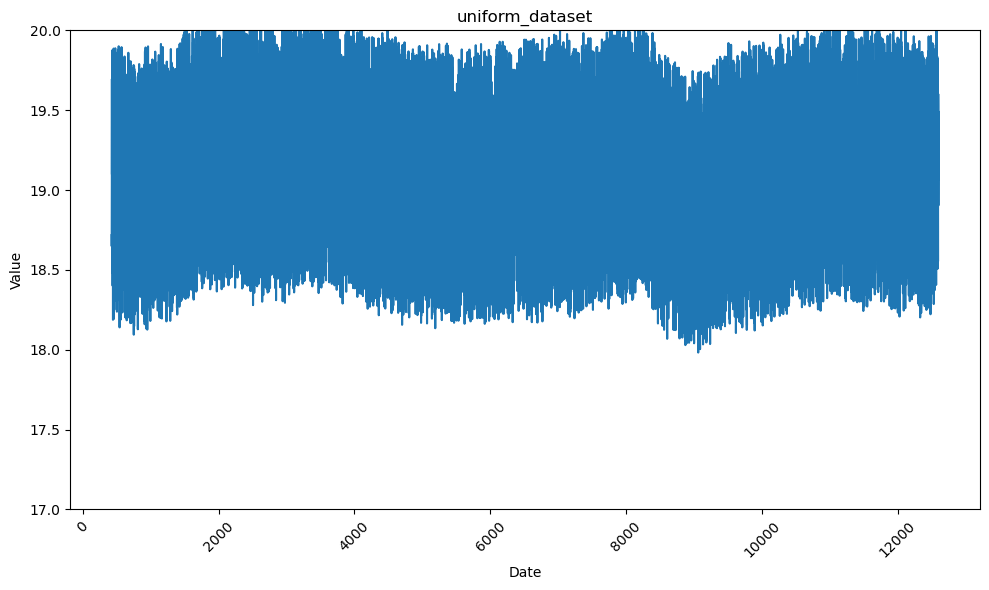

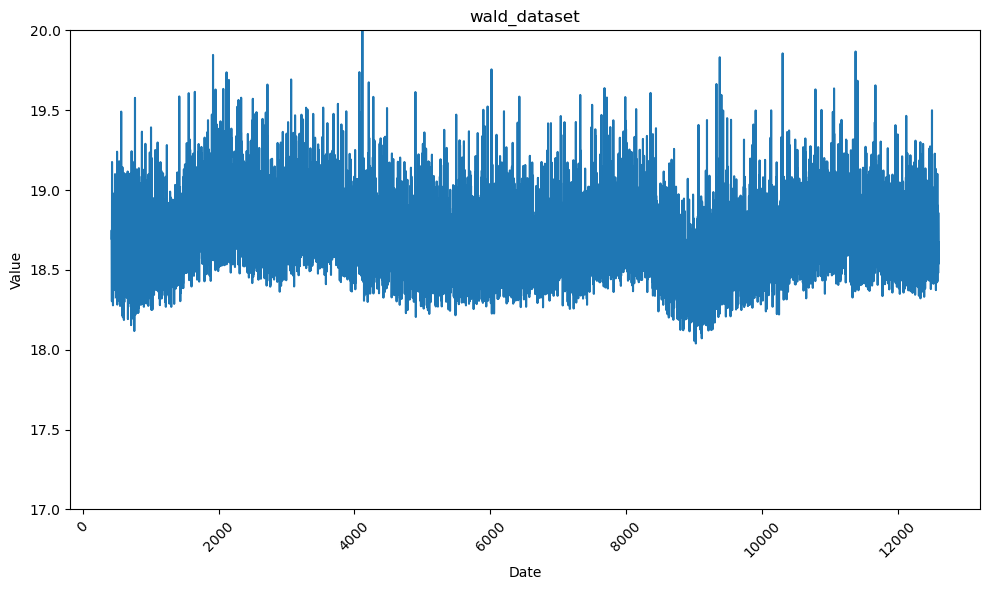

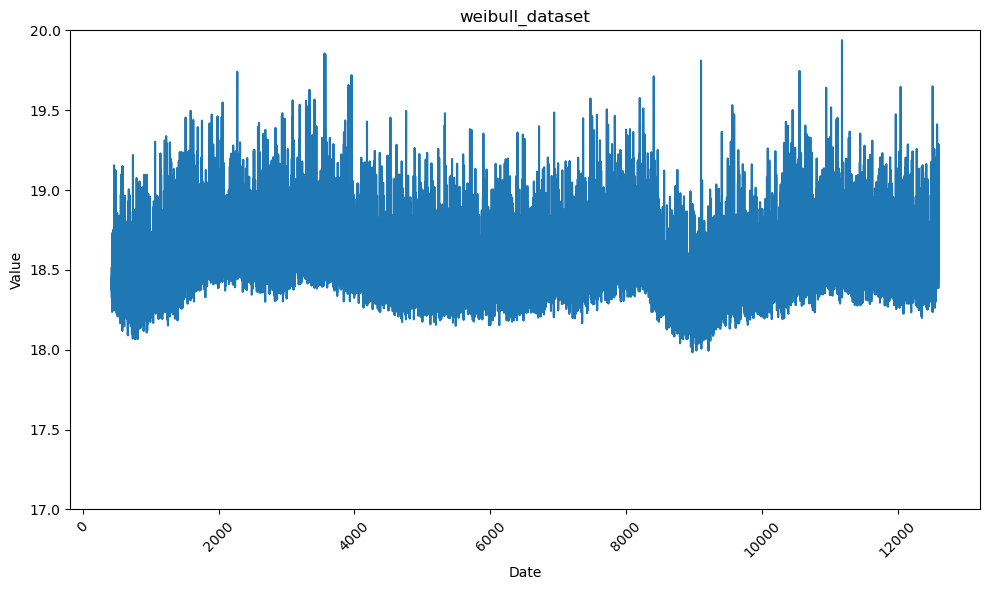

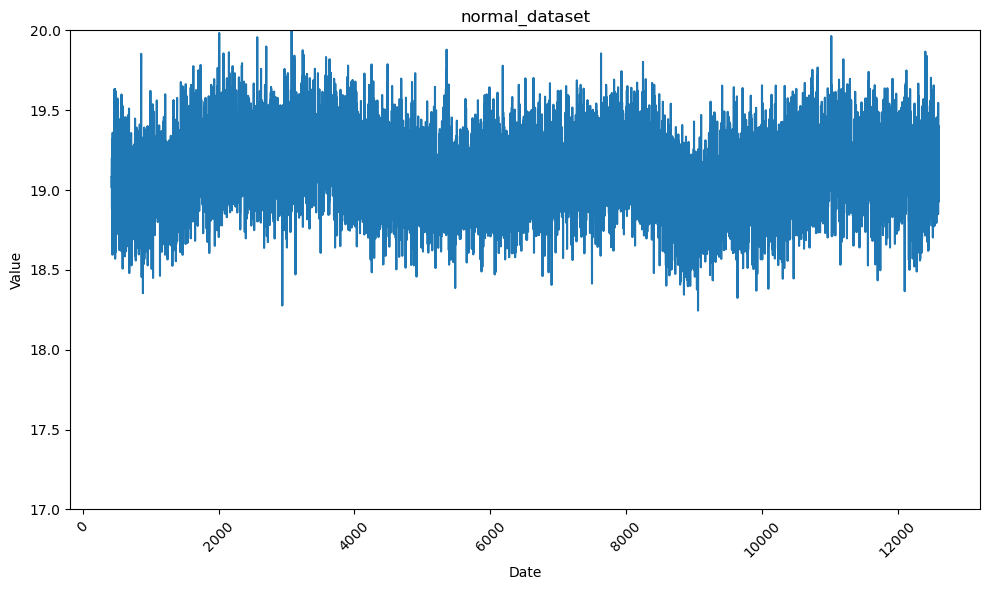

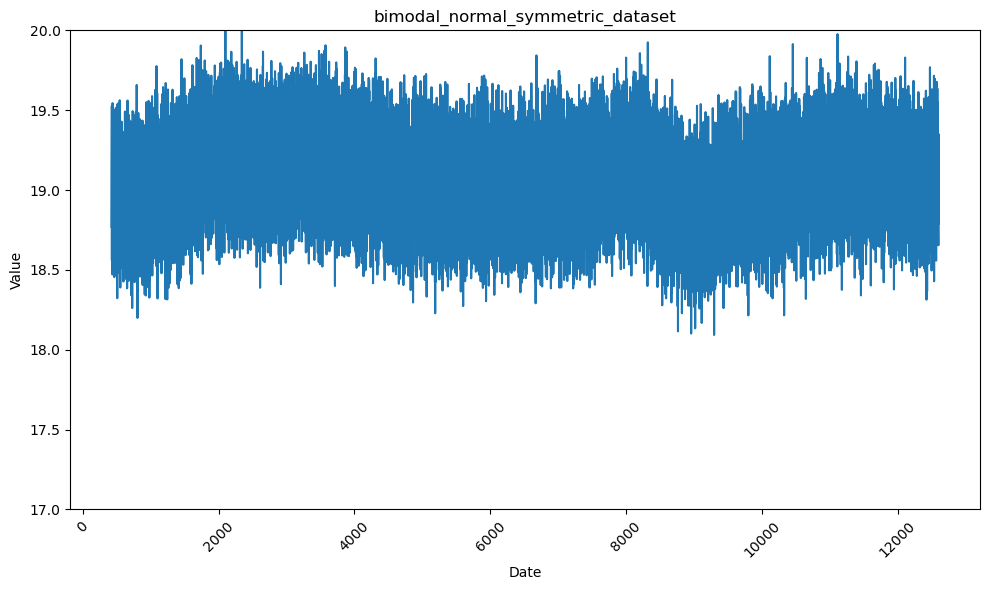

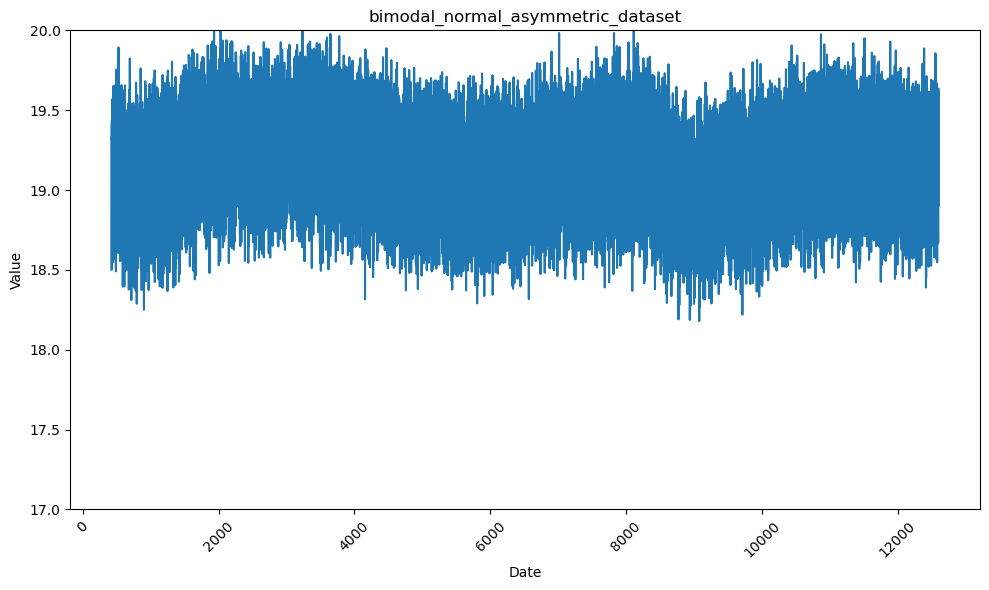

In [12]:
for col in time_series_data.columns:
    plot_time_series(time_series_data[:],col)

In [171]:
normal_data = np.array(time_series_data['normal_dataset'])
stats.normaltest(normal_data)

NormaltestResult(statistic=0.5416589127131051, pvalue=0.7627465668919475)

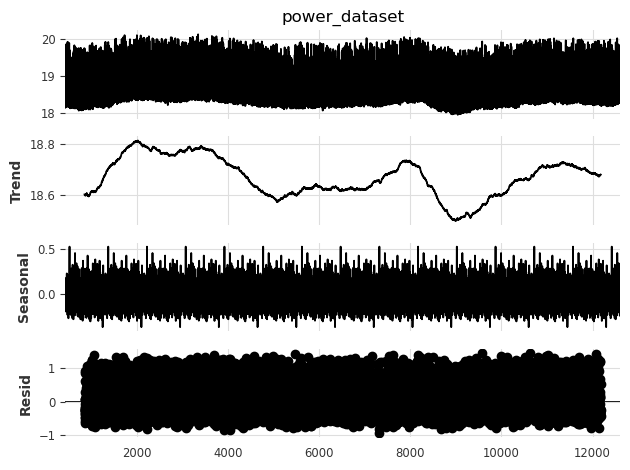

In [177]:
result = seasonal_decompose(time_series_data.iloc[:,4], model='additive',period=850) # Adjust 'period' based on your data's seasonality
result.plot()
plt.show()

In [80]:
rescaled_test = rescale(unstructured_data["exponential_dataset"], min,max)

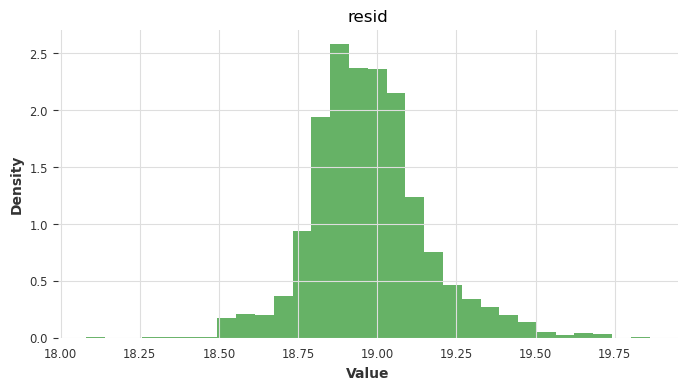

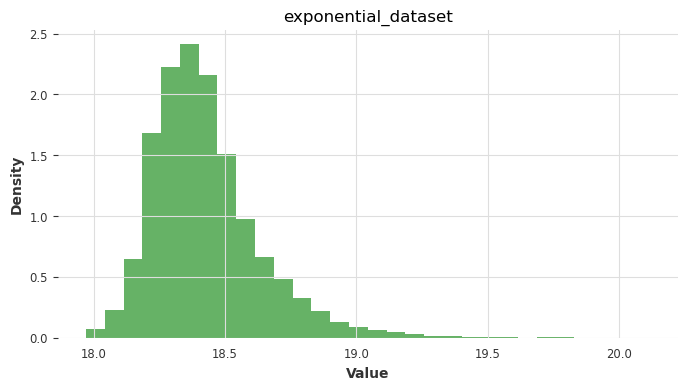

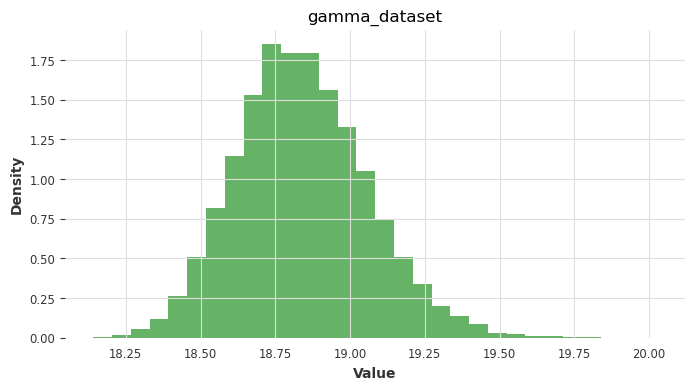

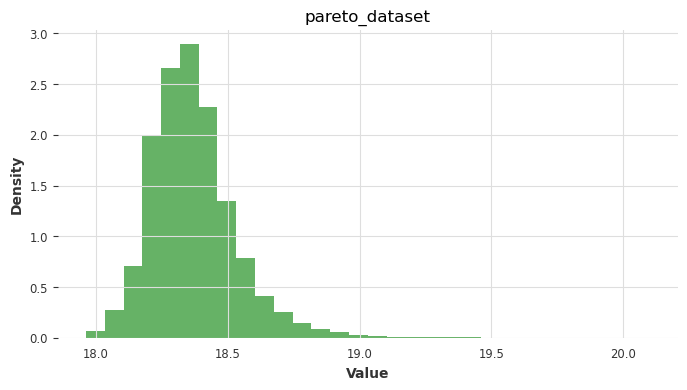

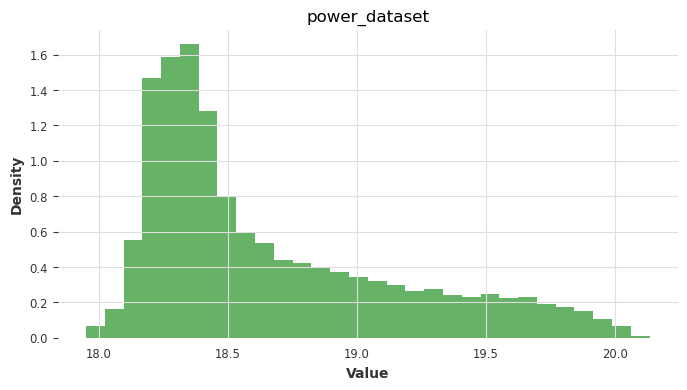

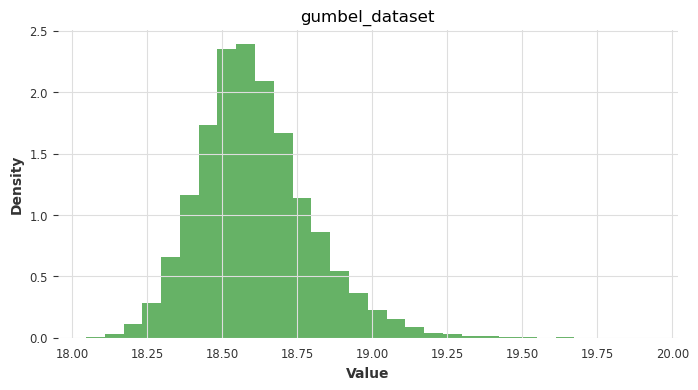

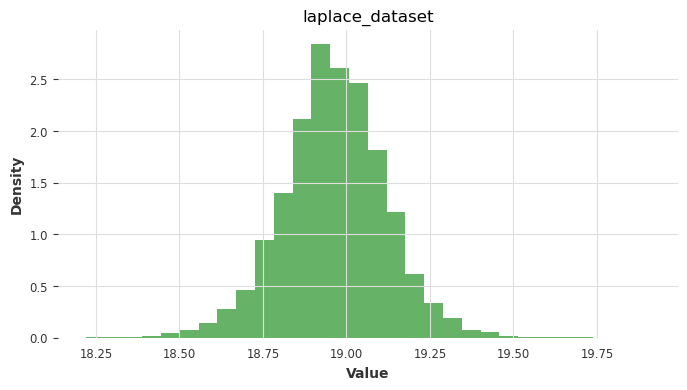

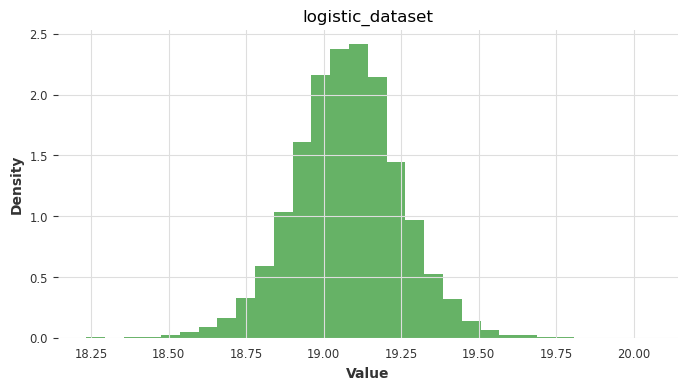

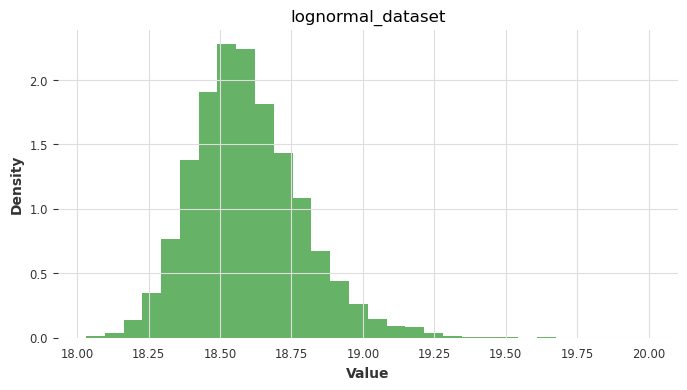

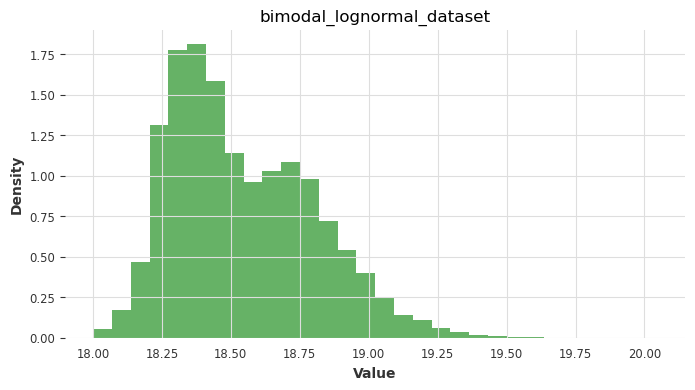

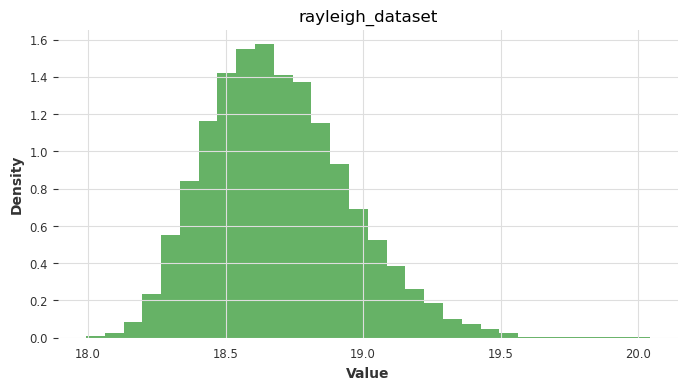

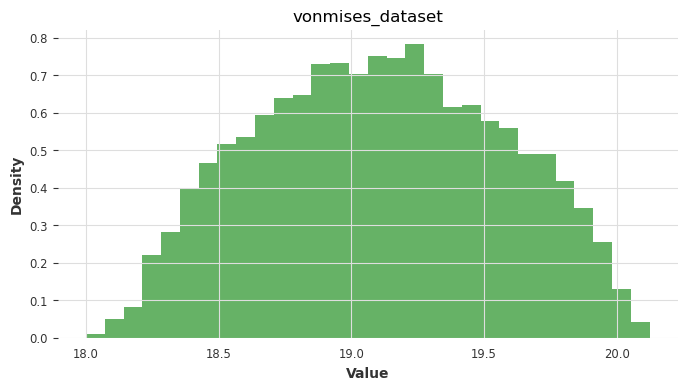

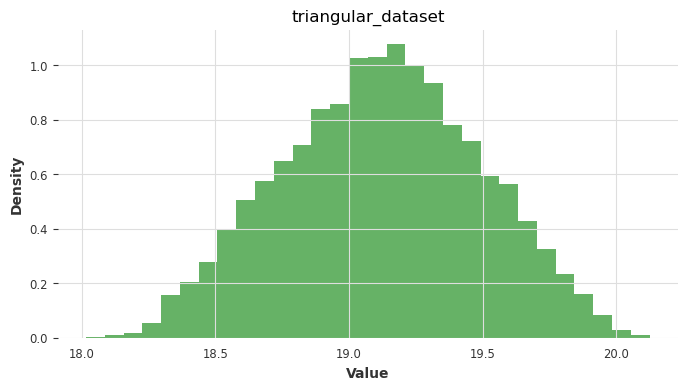

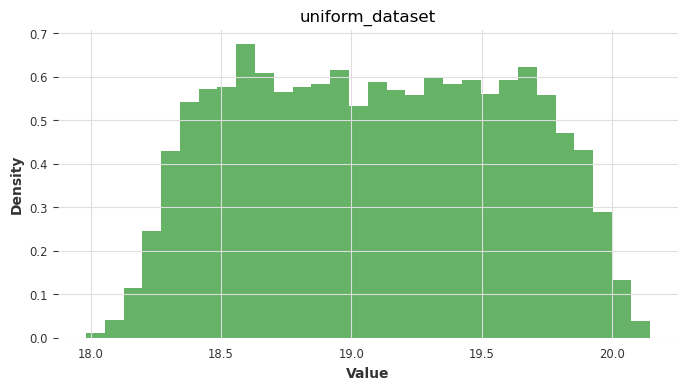

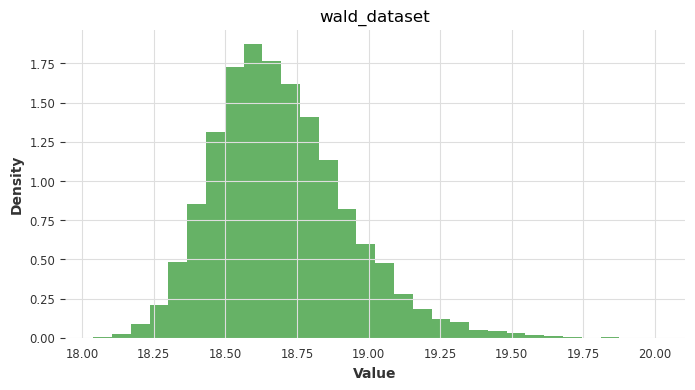

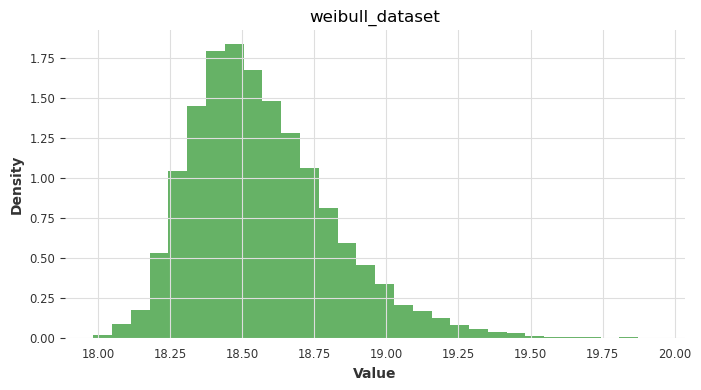

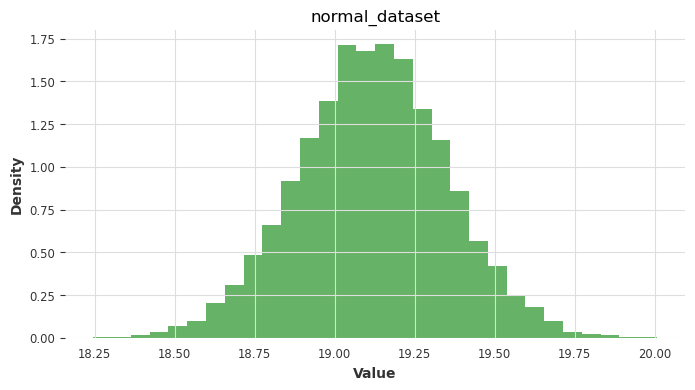

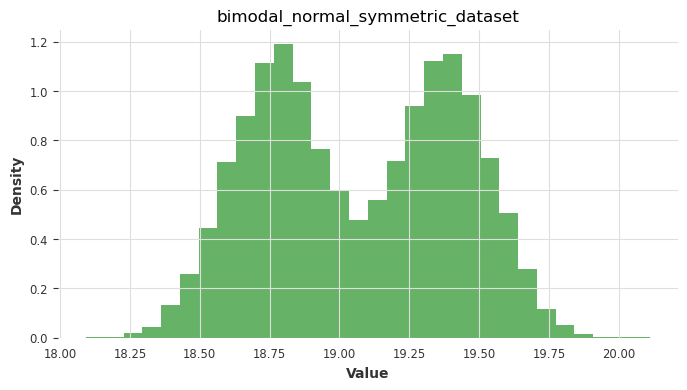

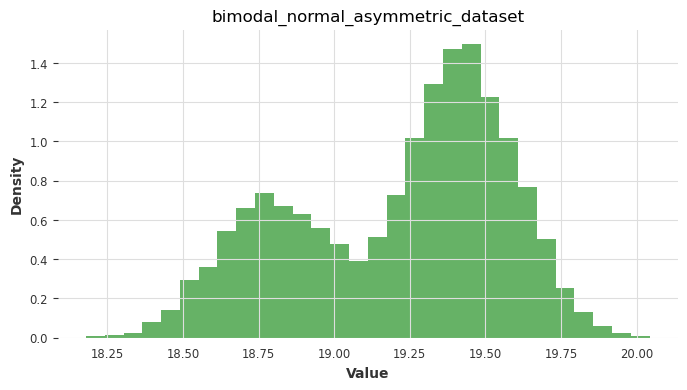

In [178]:
for i,col in enumerate(time_series_data.columns):
    plot_data(time_series_data.iloc[:,i],col)